<img src="https://wherobots.com/wp-content/uploads/2023/12/Inline-Blue_Black_onWhite@3x.png" alt="Wherobots Logo" width="900"/>


## Flights Demo

This notebook demonstrates using Wherobots Cloud and WherobotsDB to analyze aircraft flights using public ADS-B data and NOAA severe weather event data. Along the way we introduce the types of spatial queries available with WherobotsDB including spatial range queries, spatial kNN, and spatial joins using Spatial SQL, geospatial visualization options, working with with various files formats include GeoParquet, GeoTiff, ShapeFile, more. 

*Note: This notebook should be run on Wherobots Cloud using a runtime with at least 40+ cores and 100GB+ RAM, such as the New York runtime.*


<img src="https://wherobots.com/wp-content/uploads/2024/04/adsb_flights.png" alt="ADS-B Flights" width="900"/>


**Flights Traces**

* Exploratory Data Analysis
* Spatial queries & performance

**Historical Analysis Of Severe Weather Impact On Flights**

* NOAA severe weather events dataset
* Extracting flight routes from traces
* Joining weather events and flights

**Weather Forecast Impact**

* NOAA NEXRAD Doppler radar data
* Raster / vector spatial join

## Initial Configuration

In [1]:
from sedona.spark import *

In [2]:
# spark.conf.set("sedona.join.optimizationmode", "all")
config = SedonaContext.builder().config("spark.hadoop.fs.s3a.bucket.wherobots-examples.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider").config("sedona.join.optimizationmode", "all").getOrCreate()
sedona = SedonaContext.create(config)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Flight Traces

The ABS-B flight observation data comes from [ADSB.lol](https://www.adsb.lol/) which provides publicly available daily updates of crowd-sourced flight tracking data. Note that the data can be somewhat incomplete where ground-based data collection coverage is limited. We load one month of world-wide aircraft trace data which represents just over 1.1 billion point observations. We've prepared this data in GeoParquet format which is an extension to Apache Parquet that includes optimizations for working with spatial data.

In [3]:
# Load flight traces via GeoParquet
traces_df = sedona.read.format("geoparquet").load("s3a://wherobots-examples/data/examples/flights/2024_s2.parquet")

24/06/19 21:26:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
traces_df.count()

1103371367

In [5]:
traces_df.createOrReplaceTempView("traces")

In [6]:
traces_df.printSchema()

root
 |-- dbFlags: long (nullable = true)
 |-- desc: string (nullable = true)
 |-- icao: string (nullable = true)
 |-- ownOp: string (nullable = true)
 |-- r: string (nullable = true)
 |-- reg_details: struct (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- iso2: string (nullable = true)
 |    |-- iso3: string (nullable = true)
 |    |-- nation: string (nullable = true)
 |-- t: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- trace: struct (nullable = true)
 |    |-- aircraft: struct (nullable = true)
 |    |    |-- alert: long (nullable = true)
 |    |    |-- alt_geom: long (nullable = true)
 |    |    |-- baro_rate: long (nullable = true)
 |    |    |-- category: string (nullable = true)
 |    |    |-- emergency: string (nullable = true)
 |    |    |-- flight: string (nullable = true)
 |    |    |-- geom_rate: long (nullable = true)
 |    |    |-- gva: long (nullable = true)
 |    |    |-- ias: long (nullable = true)
 |    |    |-- mac

In [7]:
traces_df.show(5)

+-------+--------------------+------+-----+------+--------------------+----+-------------------+--------------------+----+--------------------+----------+-------------------+
|dbFlags|                desc|  icao|ownOp|     r|         reg_details|   t|          timestamp|               trace|year|            geometry|      date|                 s2|
+-------+--------------------+------+-----+------+--------------------+----+-------------------+--------------------+----+--------------------+----------+-------------------+
|      0|PIPER PA-28R-180/...|c81c51| null|ZK-RTE|{general, NZ, NZL...|P28R|2024-01-20 00:00:00|{{null, null, nul...|null|POINT (174.722786...|2024-01-20|7854277750134145024|
|      0|        AIRBUS A-320|c81e2c| null|ZK-OJS|{general, NZ, NZL...|A320|2024-01-15 00:00:00|{{0, 36400, 0, A3...|null|POINT (174.549826...|2024-01-15|7854277750134145024|
|      0|PIPER PA-28R-180/...|c81c51| null|ZK-RTE|{general, NZ, NZL...|P28R|2024-01-20 00:00:00|{{null, null, nul...|null|POI

After creating a temporary view we can query our aircraft traces data using Spatial SQL. Here we're demonstrating selecting fields and viewing tabular results.

In [8]:
sedona.sql("""
SELECT desc, ownOp, geometry, trace.ground_speed, trace.altitude, trace.aircraft.flight
FROM traces
WHERE trace.altitude IS NOT NULL AND OwnOp IS NOT NULL AND desc IS NOT NULL AND trace.aircraft.flight IS NOT NULL
LIMIT 10
""").show(truncate=False)

+----------------+-------------------+-----------------------------+------------+--------+--------+
|desc            |ownOp              |geometry                     |ground_speed|altitude|flight  |
+----------------+-------------------+-----------------------------+------------+--------+--------+
|AIRBUS A-350-900|UMB BANK NA TRUSTEE|POINT (174.792839 -37.010239)|122.7       |400     |DAL64   |
|AIRBUS A-350-900|UMB BANK NA TRUSTEE|POINT (174.782449 -37.013079)|161.6       |350     |DAL64   |
|AIRBUS A-350-900|UMB BANK NA TRUSTEE|POINT (174.779046 -37.01401) |168.9       |475     |DAL64   |
|AIRBUS A-350-900|UMB BANK NA TRUSTEE|POINT (174.771463 -37.016058)|165.7       |825     |DAL64   |
|AIRBUS A-350-900|UMB BANK NA TRUSTEE|POINT (174.765248 -37.017746)|162.5       |1175    |DAL64   |
|AIRBUS A-350-900|UMB BANK NA TRUSTEE|POINT (174.757827 -37.01976) |159.4       |1550    |DAL64   |
|AIRBUS A-350-900|UMB BANK NA TRUSTEE|POINT (174.748356 -37.022296)|161.3       |1950    |DAL64   |


## Flight Traces - Exploratory Data Analysis

Let's get a sense of the geographic distribution of the data. Where are we seeing the most aircraft activity? We can use H3 hexagons to aggregate the individual traces and visualize the results using SedonaKepler, the Kepler.gl integration for Sedona.

In [9]:
h3_traces_df = sedona.sql("""
SELECT
    COUNT(*) AS num,
    ST_Collect(ST_H3ToGeom(ST_H3CellIDs(geometry, 5, false))) AS geometry,
    ST_H3CellIDs(geometry, 5, false) AS h3
FROM traces
GROUP BY h3
""")

In [ ]:
SedonaKepler.create_map(h3_traces_df, name="Distribution of aircraft traces")

![](https://wherobots.com/wp-content/uploads/2024/04/flightdemo1.png)

Note that since our data source relies on crowdsourced data based on ground stations the coverage is not complete. 

### JetBlue Flight Traces

We can filter for just JetBlue aircraft and flights, then aggregate and visualize the results.

In [11]:
jbu_h3_traces_df = sedona.sql("""
SELECT
    COUNT(*) AS num,
    ST_Collect(ST_H3ToGeom(ST_H3CellIDs(geometry, 5, false))) AS geometry,
    ST_H3CellIDs(geometry, 5, false) AS h3
FROM traces
WHERE ownOp = "JETBLUE AIRWAYS CORP" AND trace.aircraft.flight LIKE "JBU%"
GROUP BY h3
""")

In [ ]:
SedonaKepler.create_map(jbu_h3_traces_df, name="Distribution of aircraft traces")

![](https://wherobots.com/wp-content/uploads/2024/04/flightdemo2.png)

## Flight Traces - Spatial Queries & Performance

WherobotsDB supports optimizations for various types of spatial queries including:

* Spatial range query
* Spatial kNN query, and
* Spatial joins

Let's demonstate these types of queries and compare the performance with this dataset.

### Spatial Range Query

<img src="https://wherobots.com/wp-content/uploads/2024/01/Screenshot-2024-01-14-at-10.33.35-AM.png" alt="Spatial range query" width="900"/>

Let's say we wanted to find all aircraft traces within the bounds of a specific area, perhaps the Gulf of Mexico region. We can do this using the `ST_Within` spatial SQL predicate.


In [13]:
gulf_filter = 'ST_Within(geometry, ST_GeomFromWKT("POLYGON ((-84.294662 29.840644, -88.952866 30.297018, -89.831772 28.767659, -94.050522 29.61167, -97.038803 27.839076, -97.917709 21.453069, -94.489975 18.479609, -86.843491 21.616579, -80.779037 24.926295, -84.294662 29.840644))"))'

gulf_traces = traces_df.where(gulf_filter)

In [14]:
%%time
gulf_traces.count()

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 5.66 s


7539347

### Spatial kNN Query

Another type of spatial query that might be relevant for working with this dataset is a *Spatial kNN query*, which will efficiently find the "k" nearest geometries. For example, let's find the nearest aircraft traces to the **Jackson Hole Airport.**


In [15]:
jackson_hole_traces = sedona.sql("""
SELECT 
    desc, 
    ownOp,
    trace.aircraft.flight, 
    ST_DistanceSphere(ST_Point(-110.7376, 43.6088), geometry) AS distance
FROM traces
ORDER BY distance ASC
LIMIT 5
""")


In [16]:
%%time

jackson_hole_traces.show()

+--------------------+--------------------+--------+------------------+
|                desc|               ownOp|  flight|          distance|
+--------------------+--------------------+--------+------------------+
|BOMBARDIER BD-700...|         FLEXJET LLC|    null| 76.92424103100763|
|        AIRBUS A-320| UNITED AIRLINES INC|    null|161.98830220247405|
|CESSNA 700 CITATI...|AH CAPITAL MANAGE...|    null|180.05761405860687|
|CESSNA 750 CITATI...|           2FLIU LLC|    null|187.01797656145476|
|DASSAULT FALCON 2000|NEXTERA ENERGY EQ...|N58MW   |204.06240031528034|
+--------------------+--------------------+--------+------------------+

CPU times: user 33.2 ms, sys: 400 μs, total: 33.6 ms
Wall time: 16.8 s


## Historical Impact of Severe Weather Events On Flights

### Weather Events

An important analysis related to flight routes is the impact of severe weather events. To enable this type of analysis Wherobots makes public a dataset of NOAA severe weather events in the [Wherobots Open Data Catalog.](https://docs.wherobots.com/latest/tutorials/opendata/introduction/?h=open+data)

In [17]:
weather = sedona.table("wherobots_pro_data.weather.weather_events")

In [18]:
weather.show()

+--------+-------------+--------+-------------------+-------------------+-----------------+----------+-----------+-----------+-----------+----+--------------+-----+-------+--------------------+
| EventId|         Type|Severity|     StartTime(UTC)|       EndTime(UTC)|Precipitation(in)|  TimeZone|AirportCode|LocationLat|LocationLng|City|        County|State|ZipCode|            geometry|
+--------+-------------+--------+-------------------+-------------------+-----------------+----------+-----------+-----------+-----------+----+--------------+-----+-------+--------------------+
|W-237263|         Cold|  Severe|2016-01-01 08:57:00|2016-01-04 15:32:00|              0.0|US/Pacific|       KNSI|    33.2338|  -119.4559|null|Ventura County|   CA|   null|POINT (-119.4559 ...|
|W-237264|         Rain|   Light|2016-01-04 22:49:00|2016-01-04 23:30:00|              0.0|US/Pacific|       KNSI|    33.2338|  -119.4559|null|Ventura County|   CA|   null|POINT (-119.4559 ...|
|W-237265|         Cold|  Seve

In [19]:
weather.printSchema()

root
 |-- EventId: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- StartTime(UTC): string (nullable = true)
 |-- EndTime(UTC): string (nullable = true)
 |-- Precipitation(in): string (nullable = true)
 |-- TimeZone: string (nullable = true)
 |-- AirportCode: string (nullable = true)
 |-- LocationLat: string (nullable = true)
 |-- LocationLng: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZipCode: string (nullable = true)
 |-- geometry: geometry (nullable = true)



In [20]:
weather.count()

8627181

## Severe Weather Events

Let's start our analysis by finding areas that are susceptible to severe weather events.

In [21]:
weather_h3_df = sedona.sql("""
SELECT
    COUNT(*) AS num,
    ST_Collect(ST_H3ToGeom(ST_H3CellIDs(ST_Buffer(geometry, 0.1), 5, false))) AS geometry,
    ST_H3CellIDs(ST_Buffer(geometry, 0.1), 5, false) AS h3
FROM wherobots_pro_data.weather.weather_events
WHERE Severity = "Severe"
GROUP BY h3
""")

In [22]:
weather_h3_df.createOrReplaceTempView("weather_h3")

In [ ]:
SedonaKepler.create_map(weather_h3_df.cache(), name="Severe weather events")

![](https://wherobots.com/wp-content/uploads/2024/04/flightdemo3.png)

## Historical Severe Weather Aircraft Trace Analysis

Now that we've determined which areas are susceptible to frequent severe weather events, we can analyze flight trace observations in these areas to determine flights that may be susceptible to frequent severe weather events using a spatial join. Note that we're joining a table with 1.1 billion observations.

In [24]:
severe_weather_flight_traces_df = sedona.sql("""
SELECT traces.geometry AS geometry, desc, ownOp, trace.aircraft.flight AS flight, num AS eventCount 
FROM traces
JOIN weather_h3
WHERE ST_Contains(weather_h3.geometry, traces.geometry) AND trace.aircraft.flight IS NOT null
""")

In [25]:
%%time
severe_weather_flight_traces_df.cache().count()

CPU times: user 23.2 ms, sys: 12.9 ms, total: 36.2 ms
Wall time: 18.5 s


53788395

In [26]:
severe_weather_flight_traces_df.show()

+--------------------+--------------------+----------------+--------+----------+
|            geometry|                desc|           ownOp|  flight|eventCount|
+--------------------+--------------------+----------------+--------+----------+
|POINT (-94.998109...|          CESSNA 310|ALSAGER JOSHUA D|N310BL  |       757|
|POINT (-95.154933...|          CESSNA 310|ALSAGER JOSHUA D|N310BL  |       765|
|POINT (-95.201111...|          CESSNA 310|ALSAGER JOSHUA D|N310BL  |       765|
|POINT (-95.232038...|          CESSNA 310|ALSAGER JOSHUA D|N310BL  |       765|
|POINT (-95.56625 ...|          CESSNA 310|ALSAGER JOSHUA D|N310BL  |      1077|
|POINT (-95.607474...|          CESSNA 310|ALSAGER JOSHUA D|N310BL  |      1077|
|POINT (-95.649987...|          CESSNA 310|ALSAGER JOSHUA D|N310BL  |      1077|
|POINT (-95.68931 ...|          CESSNA 310|ALSAGER JOSHUA D|N310BL  |      1077|
|POINT (-93.354639...|PIPER PA-28-140/1...|    ALEAGENT INC|N2108C  |       639|
|POINT (-93.350536...|PIPER 

In [27]:
severe_weather_flight_traces_df.createOrReplaceTempView("severe_weather_traces")

In [28]:
most_impacted_flights = sedona.sql("""
SELECT sum(eventCount) AS intensity, ST_Collect(collect_list(geometry)) AS geometry, flight
FROM severe_weather_traces
WHERE NOT flight = "        " AND NOT flight = "00000000"
GROUP BY flight
ORDER BY intensity DESC
LIMIT 100
""")

In [29]:
most_impacted_flights.show()

+---------+--------------------+--------+
|intensity|            geometry|  flight|
+---------+--------------------+--------+
| 29944543|MULTIPOINT ((-117...|GOJUMP3 |
| 21755551|MULTIPOINT ((-121...|N277SD  |
| 15577845|MULTIPOINT ((-118...|N930DK  |
| 15312643|MULTIPOINT ((-121...|N916SP  |
| 14019970|MULTIPOINT ((-118...|N953LA  |
| 13656148|MULTIPOINT ((-118...|N130SK  |
| 13609018|MULTIPOINT ((-81....|N6341J  |
| 13442133|MULTIPOINT ((-82....|N9526G  |
| 13181172|MULTIPOINT ((-81....|N8364U  |
| 12697030|MULTIPOINT ((-81....|N7989U  |
| 12126425|MULTIPOINT ((-117...|N950AC  |
| 12125907|MULTIPOINT ((-122...|N51HF   |
| 12033489|MULTIPOINT ((-117...|N358TV  |
| 11631484|MULTIPOINT ((-82....|N7511W  |
| 11189233|MULTIPOINT ((-118...|N737PM  |
| 11163690|MULTIPOINT ((-82....|N18728  |
| 11091120|MULTIPOINT ((-118...|N954LA  |
| 10853604|MULTIPOINT ((-120...|N545GC  |
| 10099903|MULTIPOINT ((-118...|N962LA  |
| 10090712|MULTIPOINT ((-82....|N444TH  |
+---------+--------------------+--

In [ ]:
SedonaKepler.create_map(most_impacted_flights, name="Most impacted flight traces")

![](https://wherobots.com/wp-content/uploads/2024/04/flightdemo4.png)

## JetBlue Flight Routes

So far we've been working with individual aircraft traces (point observations), but it's much more useful to analyze flights as routes. We can construct the individual flight routes from these aircraft traces. Let's find all JetBlue flights.



In [31]:
jbu_flights_df = sedona.sql("""
WITH jbu_traces AS (
    SELECT 
        any_value(trace.aircraft.flight) AS flight, 
        collect_list(ST_Point(trace.lon, trace.lat)) AS points, 
        any_value(CAST(date AS string)) AS date
    FROM traces
    WHERE ownOp = 'JETBLUE AIRWAYS CORP' AND trace.aircraft.flight IS NOT null
    GROUP BY trace.aircraft.flight, date
)
SELECT flight, ST_MakeLine(points) AS geometry, date 
FROM jbu_traces
WHERE size(points) > 100
""")

In [32]:
jbu_flights_df.show()

+--------+--------------------+----------+
|  flight|            geometry|      date|
+--------+--------------------+----------+
|JBU100  |LINESTRING (-112....|2024-01-24|
|JBU101  |LINESTRING (-80.1...|2024-01-21|
|JBU1016 |LINESTRING (-77.3...|2024-01-20|
|JBU1044 |LINESTRING (-80.1...|2024-01-10|
|JBU1053 |LINESTRING (-73.7...|2024-01-03|
|JBU1055 |LINESTRING (-71.0...|2024-01-03|
|JBU1060 |LINESTRING (-77.4...|2024-01-12|
|JBU1060 |LINESTRING (-77.4...|2024-01-26|
|JBU1067 |LINESTRING (-73.7...|2024-01-17|
|JBU1068 |LINESTRING (-80.0...|2024-01-24|
|JBU1114 |LINESTRING (-112....|2024-01-17|
|JBU1131 |LINESTRING (-80.2...|2024-01-22|
|JBU1136 |LINESTRING (-83.3...|2024-01-15|
|JBU1142 |LINESTRING (-80.0...|2024-01-27|
|JBU1196 |LINESTRING (-80.1...|2024-01-03|
|JBU1196 |LINESTRING (-80.1...|2024-01-27|
|JBU1217 |LINESTRING (-81.6...|2024-01-15|
|JBU1230 |LINESTRING (-86.4...|2024-01-22|
|JBU1238 |LINESTRING (-97.6...|2024-01-28|
|JBU1251 |LINESTRING (-73.7...|2024-01-10|
+--------+-

In [33]:
jbu_flights_df.count()

14277

In [34]:
jbu_flights_df.createOrReplaceTempView("jbu_flights")

In [ ]:
SedonaKepler.create_map(jbu_flights_df, name="JetBlue flight routes")

![](https://wherobots.com/wp-content/uploads/2024/04/flightdemo5.png)

## Identify Potential For Weather Impacted Flights

### Creating Uniform Flight Route Segments

To analyze which flights have the most potential to be impacted based on historical weather events, we first create 100km segments of each flight which will allow us to identify not only entire flight routes that are potentially impacted by weather events, but specific flight segments with the most risk of disruption.

In [36]:
from shapely.geometry import LineString, MultiLineString
from sedona.sql.types import GeometryType

# Define a Shapely UDF to create a series of consistent length line segments for each flight
def interpolate_lines(line: GeometryType()):
    try:
        distance_delta = 1.0 # ~100km
        points_count = int(line.length // distance_delta) + 1
        distances = (distance_delta * i for i in range(points_count))
        points = [line.interpolate(distance) for distance in distances] + [line.boundary.geoms[1]]
        line_strings = []
        for i in range(len(points) - 1):
            line_strings.append(LineString([points[i], points[i+1]]))
        return MultiLineString(line_strings)
    except:
        return None

In [37]:
sedona.udf.register("interpolate_lines", interpolate_lines, GeometryType())

<function __main__.interpolate_lines(line: GeometryType())>

In [38]:
split_df = sedona.sql("""
SELECT flight, date, explode(ST_Dump(interpolate_lines(geometry))) AS geometry
FROM jbu_flights
""")

In [39]:
%%time
split_df.count()

CPU times: user 17.7 ms, sys: 23.9 ms, total: 41.5 ms
Wall time: 9.82 s


546052

In [40]:
split_df.show()

+--------+----------+--------------------+
|  flight|      date|            geometry|
+--------+----------+--------------------+
|JBU100  |2024-01-24|LINESTRING (-118....|
|JBU100  |2024-01-24|LINESTRING (-117....|
|JBU100  |2024-01-24|LINESTRING (-116....|
|JBU100  |2024-01-24|LINESTRING (-115....|
|JBU100  |2024-01-24|LINESTRING (-114....|
|JBU100  |2024-01-24|LINESTRING (-113....|
|JBU100  |2024-01-24|LINESTRING (-112....|
|JBU100  |2024-01-24|LINESTRING (-111....|
|JBU100  |2024-01-24|LINESTRING (-110....|
|JBU100  |2024-01-24|LINESTRING (-109....|
|JBU100  |2024-01-24|LINESTRING (-108....|
|JBU100  |2024-01-24|LINESTRING (-107....|
|JBU100  |2024-01-24|LINESTRING (-106....|
|JBU100  |2024-01-24|LINESTRING (-105....|
|JBU100  |2024-01-24|LINESTRING (-104....|
|JBU100  |2024-01-24|LINESTRING (-103....|
|JBU100  |2024-01-24|LINESTRING (-102....|
|JBU100  |2024-01-24|LINESTRING (-102....|
|JBU100  |2024-01-24|LINESTRING (-101....|
|JBU100  |2024-01-24|LINESTRING (-100....|
+--------+-

In [41]:
split_df.createOrReplaceTempView("split_flights")

In [42]:
#SedonaKepler.create_map(split_df.sample(0.01))

### Joining Flight Route Segments With Weather Events

Now we perform a spatial join to identify flight segments that pass through areas that historically have a high frequency of severe weather events.

In [43]:
severe_weather_split_df = sedona.sql("""
SELECT flight, date, split_flights.geometry AS geometry, num 
FROM split_flights
JOIN weather_h3
WHERE ST_Intersects(weather_h3.geometry, split_flights.geometry)
""")

In [44]:
%%time

severe_weather_split_df.count()

CPU times: user 25.4 ms, sys: 4.14 ms, total: 29.5 ms
Wall time: 8.93 s


382082

In [45]:
severe_weather_split_df.show()

+--------+----------+--------------------+----+
|  flight|      date|            geometry| num|
+--------+----------+--------------------+----+
|JBU197  |2024-01-07|LINESTRING (-91.1...| 932|
|JBU197  |2024-01-07|LINESTRING (-92.1...| 807|
|JBU197  |2024-01-07|LINESTRING (-94.1...| 713|
|JBU197  |2024-01-07|LINESTRING (-97.1...|1838|
|JBU197  |2024-01-07|LINESTRING (-112....| 212|
|JBU197  |2024-01-07|LINESTRING (-112....|1143|
|JBU197  |2024-01-07|LINESTRING (-113....| 212|
|JBU197  |2024-01-07|LINESTRING (-116....| 622|
|JBU197  |2024-01-07|LINESTRING (-119....| 618|
|JBU197  |2024-01-07|LINESTRING (-119....| 686|
|JBU197  |2024-01-07|LINESTRING (-113....|1114|
|JBU197  |2024-01-07|LINESTRING (-110....| 424|
|JBU197  |2024-01-07|LINESTRING (-109....| 424|
|JBU197  |2024-01-07|LINESTRING (-102....|1232|
|JBU197  |2024-01-07|LINESTRING (-102....|1006|
|JBU197  |2024-01-07|LINESTRING (-95.8...|1077|
|JBU197  |2024-01-07|LINESTRING (-94.9...|1538|
|JBU197  |2024-01-07|LINESTRING (-93.9..

In [46]:
#SedonaKepler.create_map(severe_weather_split_df.sample(.001))

In [47]:
severe_weather_split_df.createOrReplaceTempView("weather_split")

In [48]:
intensity_df = sedona.sql("""
SELECT sum(num) AS intensity, flight, date, ST_Collect(collect_list(geometry)) AS geometry
FROM weather_split
GROUP BY flight, date
ORDER BY intensity DESC
""")

In [49]:
intensity_df.createOrReplaceTempView("jbu_intensity")

In [50]:
intensity_df.show()

+---------+--------+----------+--------------------+
|intensity|  flight|      date|            geometry|
+---------+--------+----------+--------------------+
|   117291|JBU778  |2024-01-04|MULTILINESTRING (...|
|   117230|JBU424  |2024-01-03|MULTILINESTRING (...|
|   104229|JBU620  |2024-01-15|MULTILINESTRING (...|
|   103601|JBU1975 |2024-01-04|MULTILINESTRING (...|
|   103572|JBU888  |2024-01-13|MULTILINESTRING (...|
|   103545|JBU197  |2024-01-24|MULTILINESTRING (...|
|   101690|JBU1566 |2024-01-08|MULTILINESTRING (...|
|   101175|JBU197  |2024-01-27|MULTILINESTRING (...|
|    99556|JBU1566 |2024-01-04|MULTILINESTRING (...|
|    97961|JBU33   |2024-01-28|MULTILINESTRING (...|
|    97464|JBU1515 |2024-01-23|MULTILINESTRING (...|
|    97299|JBU932  |2024-01-13|MULTILINESTRING (...|
|    92905|JBU932  |2024-01-30|MULTILINESTRING (...|
|    92704|JBU416  |2024-01-14|MULTILINESTRING (...|
|    91867|JBU815  |2024-01-14|MULTILINESTRING (...|
|    91217|JBU333  |2024-01-24|MULTILINESTRING

In [51]:
intensity_df.count()

14213

In [ ]:
SedonaKepler.create_map(intensity_df, name="Frequently weather impacted flight segments")

![](https://wherobots.com/wp-content/uploads/2024/04/flightdemo6.png)

### Flights With The Highest Potential For Weather Impact

In [53]:
full_flight_intensity_df = sedona.sql("""
SELECT jbu_flights.flight, jbu_flights.geometry, jbu_flights.date, intensity
FROM jbu_flights
JOIN jbu_intensity ON jbu_flights.flight = jbu_intensity.flight AND jbu_flights.date = jbu_intensity.date
""")

In [ ]:
map_view = SedonaKepler.create_map(full_flight_intensity_df.orderBy("intensity", ascending=False).limit(10), name="Flights")
SedonaKepler.add_df(map_view, df=weather_h3_df, name="Weather")
map_view

![](https://wherobots.com/wp-content/uploads/2024/04/flightdemo7.png)

## Highest Potentially Weather Impacted Flights

* JBU888 - LAX to BOS
* JBU424 - LAX to JFK
* JBU620 - SAN to BOS
* JBU197 - BOX to SEA
* JBU778 - LAS to BOS

## Weather Forecast Analysis - Doppler Radar Raster Data

So far we've been working with historical weather event data, lets look at a simple example using more real-time weather radar data. Specifically, we'll use [NOAA's NEXRAD Doppler weather radar](https://www.ncei.noaa.gov/products/radar/next-generation-weather-radar) surface reflectivity product to assess the impact of high precipitation at airports.


In [55]:
nexrad_raster_url = "s3://wherobots-examples/data/noaa/nexrad/n0q_202309231625.tif"
nexrad_df = sedona.sql(f"SELECT RS_FromPath('{nexrad_raster_url}') AS raster")
nexrad_df.createOrReplaceTempView("nexrad")
nexrad_df.printSchema()

root
 |-- raster: raster (nullable = true)



In [56]:
sedona.sql("SELECT RS_MetaData(raster) from nexrad").show(truncate=False)

+---------------------------------------------------------------------------+
|rs_metadata(raster)                                                        |
+---------------------------------------------------------------------------+
|[-126.0025, 50.0025, 12200.0, 5400.0, 0.005, -0.005, 0.0, 0.0, 4326.0, 1.0]|
+---------------------------------------------------------------------------+



In [57]:
sedona.sql("SELECT RS_NumBands(raster) FROM nexrad").show()

+-------------------+
|rs_numbands(raster)|
+-------------------+
|                  1|
+-------------------+



,raster_image
0,

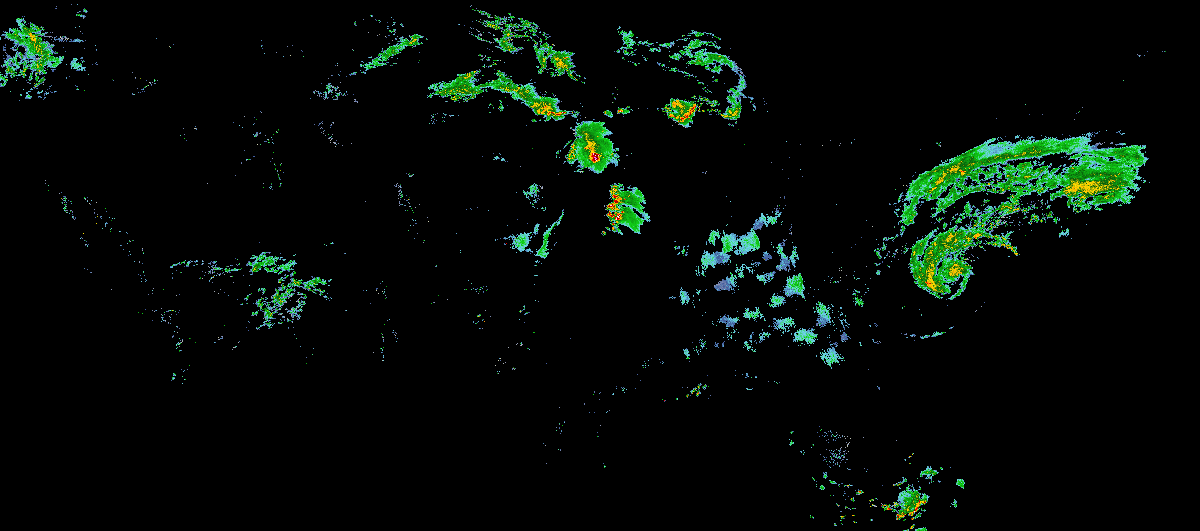

In [58]:
htmlDf = sedona.sql("SELECT RS_AsImage(raster, 1200) AS raster_image FROM nexrad")
SedonaUtils.display_image(htmlDf)

In [59]:
spatialRdd = ShapefileReader.readToGeometryRDD(sedona.sparkContext, "s3a://wherobots-examples/data/ne_50m_airports")
poi_df = Adapter.toDf(spatialRdd, sedona)

poi_df = poi_df
poi_df.show(5)
poi_df.createOrReplaceTempView("airports")

+--------------------+---------+----------+-----+----------------+------+--------+--------+---------+--------------------+---------+
|            geometry|scalerank|featurecla| type|            name|abbrev|location|gps_code|iata_code|           wikipedia|natlscale|
+--------------------+---------+----------+-----+----------------+------+--------+--------+---------+--------------------+---------+
|POINT (113.935016...|        2|   Airport|major| Hong Kong Int'l|   HKG|terminal|    VHHH|      HKG|http://en.wikiped...|  150.000|
|POINT (121.231370...|        2|   Airport|major|         Taoyuan|   TPE|terminal|    RCTP|      TPE|http://en.wikiped...|  150.000|
|POINT (4.76437693...|        2|   Airport|major|        Schiphol|   AMS|terminal|    EHAM|      AMS|http://en.wikiped...|  150.000|
|POINT (103.986413...|        2|   Airport|major|Singapore Changi|   SIN|terminal|    WSSS|      SIN|http://en.wikiped...|  150.000|
|POINT (-0.4531566...|        2|   Airport|major| London Heathrow|   

In [60]:
airport_precip_df = sedona.sql("""
SELECT name, iata_code, type, RS_Value(raster, geometry, 1) AS precip
FROM airports
JOIN nexrad 
""")

In [61]:
airport_precip_df.where("precip > 100").show(truncate=False)

+-------------------+---------+-----+------+
|name               |iata_code|type |precip|
+-------------------+---------+-----+------+
|Gen E L Logan Int'l|BOS      |major|108.0 |
|Durham Int'l       |RDU      |major|138.0 |
+-------------------+---------+-----+------+



Based on this analysis we can see that Logan International Airport and Raleigh-Durham Airport are experiencing high precipitation events, which may potentially impact ground operations.